Naive Risk Budgeting Strategies between the PSP and GHP

In [32]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import Easy_Risk_Kit as erk


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def bt_mix(r1, r2, allocator, **kwargs):
    """
    Returns T*N DataFrame of the resulting N portfolio scenarios
    """
    if not r1.shape==r2.shape:
        raise ValueError(" r1 and r2 need to be the same shape")
    weights=allocator(r1,r2, **kwargs)# allocator will take r1 and r2 and a bunch of other things
    if not weights.shape==r1.shape:
        raise ValueError("Allocator returned weights that don't match r1")
    r_mix=weights*r1+(1-weights)*r2
    return r_mix
    

In [8]:
def fixedmix_allocator(r1, r2, w1, **kwargs):
    """
    Return a t*N DataFrame of PSP weights
    """
    return pd.DataFrame(data=w1, index=r1.index, columns=r1.columns)
    
    

In [12]:
rates, zc_prices=erk.cir(10, 500, b=0.03, r_0=0.03)
price_10=erk.bond_price(10, 100, 0.05, 12, rates)
price_30=erk.bond_price(30, 100, 0.05, 12, rates)
rets_30=erk.bond_total_return(price_30, 100,0.05,12)
rets_10=erk.bond_total_return(price_10, 100,0.05,12)
rets_bonds=erk.bt_mix(rets_10, rets_30, allocator=erk.fixedmix_allocator, w1=.6)
mean_rets_bonds=rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-fisher Var(5%),Historic CVaR(5%),Sharpe Ratio,Max Drawdown
0,0.036626,0.003132,0.486267,3.102467,-0.001652,-0.001557,2.05935,0.0


In [18]:
price_eq=erk.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
rets_eq=price_eq.pct_change().dropna()
rets_zc=zc_prices.pct_change().dropna()


In [19]:
rets_7030b=erk.bt_mix(rets_eq, rets_bonds, allocator=erk.fixedmix_allocator, w1=0.7)
rets_7030b_mean =rets_7030b.mean(axis=1)
erk.summary_stats(pd.DataFrame(rets_7030b_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-fisher Var(5%),Historic CVaR(5%),Sharpe Ratio,Max Drawdown
0,0.059565,0.005062,-0.216238,2.499598,-0.002338,-0.001821,5.684297,0.0


In [20]:
summaries=erk.summary_stats(rets_7030b)

In [21]:
summaries.head()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-fisher Var(5%),Historic CVaR(5%),Sharpe Ratio,Max Drawdown
0,0.053830,0.109996,-0.139708,2.649095,0.048601,0.062214,0.210717,-0.170801
1,0.083965,0.116992,-0.256997,2.843207,0.050534,0.067037,0.448818,-0.287749
2,0.063568,0.103503,-0.070761,3.204512,0.043823,0.057299,0.315534,-0.227808
3,0.089905,0.108671,0.070349,2.819738,0.043187,0.056456,0.536415,-0.125565
4,0.039059,0.100710,0.031967,2.669763,0.043934,0.052752,0.087427,-0.198057


If you have the money to get a zero bound and a 100% funding ratio then you're good. You have all the money you need so start moving to bonds. 
But the more money you put in PSP, the better chance that you hit your liability.


In [19]:
#p_breach, the probability that you fall bellow the floor is almost 0

In [22]:
summaries.mean()

Annualized Return         0.053958
Annualized Vol            0.107975
Skewness                  0.008116
Kurtosis                  2.948602
Cornish-fisher Var(5%)    0.046151
Historic CVaR(5%)         0.058291
Sharpe Ratio              0.216467
Max Drawdown             -0.210986
dtype: float64

In [23]:
#compute the statistics on each different sencario then do the avg ( average the statistics not the returns)

In [25]:
def terminal_value(rets):
    """
    Returns the final value at the end of the return period for each scenario
    """
    
    return (rets+1).prod()

In [35]:
pd.concat([
    erk.terminal_stats(rets_bonds, name="FI"), 
    erk.terminal_stats(rets_eq, name="Eq"),
    erk.terminal_stats(rets_7030b, name="70/30")
], axis=1)

,FI,Eq,70/30
mean,1.394275,1.925334,1.764423
std,0.106047,0.853254,0.541799
p_breach,NaN,0.050000,0.014000
e_short,NaN,0.133102,0.039370
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [36]:
import seaborn as sns

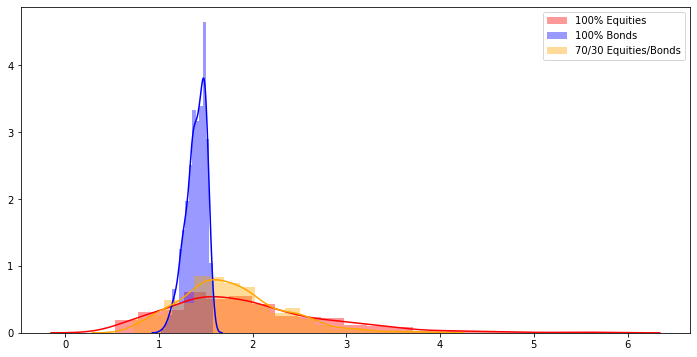

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(erk.terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
plt.legend()

#Glid path for allocation

In [47]:
def glidpath_allocator( r1, r2, start_glide=1, end_glide=0):
    """
    Gradualy move from r1 to r2
    """
    n_points= r1.shape[0]
    n_col=r1.shape[1]
    path= pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    paths=pd.concat([path]*n_col, axis=1)
    paths.index=r1.index
    paths.columns=r1.columns
    return paths

In [48]:
rets_g8020=erk.bt_mix(rets_eq, rets_bonds, allocator=erk.glidpath_allocator, start_glide=.80, end_glide=.20)

In [50]:
pd.concat([
    erk.terminal_stats(rets_bonds, name="FI"), 
    erk.terminal_stats(rets_eq, name="Eq"),
    erk.terminal_stats(rets_7030b, name="70/30"),
    erk.terminal_stats(rets_g8020, name="Glide 80 to 20")
], axis=1)

,FI,Eq,70/30,Glide 80 to 20
mean,1.394275,1.925334,1.764423,1.641494
std,0.106047,0.853254,0.541799,0.390865
p_breach,NaN,0.050000,0.014000,0.002000
e_short,NaN,0.133102,0.039370,0.001726
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [51]:
#breaches still exits but doesn't realy solve the problem